# Mixed-Frequency Data
by **Professor Throckmorton**  
for *Time Series Econometrics*  
W&amp;M ECON 408/PUBP 616  
<a href="mixed-frequency-data.slides.html">Slides</a>

## Summary

- In the [Data in Python Notebook](./data-in-python.ipynb), we read one time series, Real GDP, from FRED.
- This Jupyter Notebook will demonstrate how to use a `for` loop to read and plot multiple time series in Python.
- These time series will have **mixed frequencies**, e.g., daily, monthly, quarterly, annual.

## Reading data

- Let's create a Data Frame with three columns, a `DATE` index, `RGDP` (Real GDP), and `PCEPI` (Personal Consumption Expenditures Price Index).
- Our goal is to plot the Real GDP Growth Rate and an inflation rate based on `PCEPI`, which is a measure of the average price of consumption goods in the U.S.
- We can create a Data Frame and assign the columns/variables using a [for loop](https://www.w3schools.com/python/python_for_loops.asp). This is especially useful if you have data from different sources (i.e., FRED and some other sources).

In [7]:
# Libraries
from fredapi import Fred
import pandas as pd
# Setup acccess to FRED
fred_api_key = pd.read_csv('fred_api_key.txt', header=None)
fred = Fred(api_key=fred_api_key.iloc[0,0])
# Series to get
series = ['GDPC1','PCEPI']
# Get and append data to list
dl = []
for _, string in enumerate(series):
    var = fred.get_series(string).to_frame(name=string)
    dl.append(var)
    print(var.head(2)); print(var.tail(2))

              GDPC1
1947-01-01 2,182.68
1947-04-01 2,176.89
               GDPC1
2025-01-01 23,512.72
2025-04-01 23,685.29
            PCEPI
1959-01-01  15.16
1959-02-01  15.18
            PCEPI
2025-05-01 126.20
2025-06-01 126.56


- `for _, string in enumerate(series):` is a for loop that assigns a string, `string`, to each element of `series`.
- `dl` is a list with the data, notice the variables do not share the same datetime index, one is **quarterly** and the other is **monthly**, i.e., the data has **mixed frequency**. Furthermore, the first and last date of each variable is different.

In [2]:
# Concatenate data to create data frame (time-series table)
df = pd.concat(dl, axis=1).sort_index()
df.columns = ['RGDP','PCEPI']

# Display data
print(f'len(df) = {len(df)}')
print(df.head(4))
print(df.tail(4))

len(df) = 846
                RGDP  PCEPI
1947-01-01  2182.681    NaN
1947-04-01  2176.892    NaN
1947-07-01  2172.432    NaN
1947-10-01  2206.452    NaN
                 RGDP    PCEPI
2025-03-01        NaN  125.791
2025-04-01  23685.287  125.990
2025-05-01        NaN  126.201
2025-06-01        NaN  126.555


- `pd.concat` creates a data frame (time-series table), `df`, with a common datetime index but with mixed-frequency data, i.e., `RGDP` has values every quarter and `PCEPI` has values every month and any missing values are filled in with `NaN` (i.e., *Not a Number*)

In [3]:
# Resample/reindex to quarterly frequency
df = df.resample('QE').last()
        
# Display data
print(f'len(df) = {len(df)}')
print(df.head(2))
print(df.tail(2))

len(df) = 314
                RGDP  PCEPI
1947-03-31  2182.681    NaN
1947-06-30  2176.892    NaN
                 RGDP    PCEPI
2025-03-31  23512.717  125.791
2025-06-30  23685.287  126.555


- `df` had mix-frequency data. The pandas methods `resample` resamples the data frame to a desired common frequency, which is usually the lowest frequency of all the variables. That is a quarterly frequency here.
- `resample('QE-DEC').last()` resamples all variables to a quarterly frequency using the last value in each quarterly interval, and it reindexes the entire DataFrame such that each value corrresponds to the last day of the quarter (and is now standard practice in `pandas`, in contrast to FRED where each quarterly value was assigned to the first day).
- `df` now contains fewer rows, one for each quarter. The variable `PCEPI` is still `NaN` at the beginning of the sample, and `RGDP` is missing a value for the end of the sample.

In [4]:
# Import libraries
import numpy as np
# Real GDP Growth Rate (percent change)
df['logRGDP'] = np.log(df.RGDP)
df['growth_rate'] = 100*(df.logRGDP - df.logRGDP.shift(4))

# PCE inflation rate (percent change)
df['logPCEPI'] = np.log(df.PCEPI)
df['inf_rate'] = 100*(df.logPCEPI - df.logPCEPI.shift(4))

# Display data
pd.options.display.float_format = '{:,.2f}'.format
print(df.tail(4))

# Latest Real GDP value
print()
print(f'2024Q3 real GDP Year over Year Growth Rate = \
{df.growth_rate['2024-09-30']:.2f}%')

                RGDP  PCEPI  logRGDP  growth_rate  logPCEPI  inf_rate
2024-09-30 23,400.29 123.94    10.06         2.68      4.82      2.08
2024-12-31 23,542.35 124.77    10.07         2.50      4.83      2.57
2025-03-31 23,512.72 125.79    10.07         1.97      4.83      2.32
2025-06-30 23,685.29 126.56    10.07         1.97      4.84      2.55

2024Q3 real GDP Year over Year Growth Rate = 2.68%


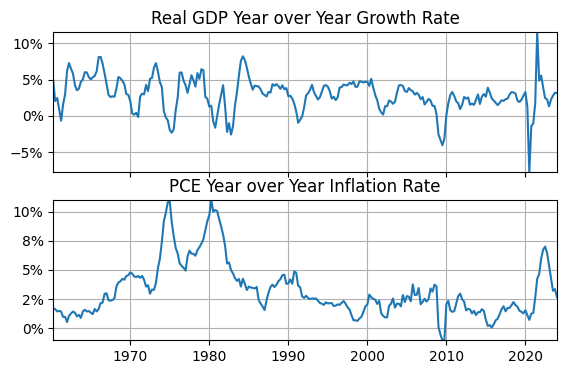

In [5]:
# Import libraries
import matplotlib.pyplot as plt
# Plot options
#  Sub sample
date_start = '01-01-1960'
date_end = '12-31-2023'
#  Variables to plot
#    Variable       Plot title
plotme = [
    ['growth_rate', 'Real GDP Year over Year Growth Rate'],
    ['inf_rate',    'PCE Year over Year Inflation Rate']]
# Plot variables
fig, axs = plt.subplots(len(plotme),figsize=(6.5,4))
for idx, ax in enumerate(axs.flat):
    ax.plot(df[plotme[idx][0]][date_start:date_end])
    ax.set_title(plotme[idx][1])
    ax.yaxis.set_major_formatter('{x:.0f}%')
    ax.grid(); ax.autoscale(tight=True); ax.label_outer()

- `plt.subplots(len(vars))` creates a figure with 2 subplots
- `for idx, ax in enumerate(axs.flat):` is a for loop that assigns an integer index, `idx`, and axis handle, `ax`, to each element of `axs.flat` that indicate the subplot being formatted and where the data is plotted.
- `ax.label_outer()` skips the year label on the first plot and only shows it on the second axis.

## Conclusion

We used a `for` loop to assign multiple time series to a `pandas` DataFrame. Then we resampled the variables in the DataFrame to a common lower frequency. Based on those values, we calculated year-over-year real GDP growth and PCE inflation rates. Finally, we used a loop to plot both rates in a single figure.